In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import warnings
warnings.filterwarnings("ignore")


In [2]:
import os, cv2, glob
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10

DATASET = "C:/Users/harsh/Downloads/28455641/TN5000_forReview/TN5000"
IMG_DIR = f"{DATASET}/JPEGImages"
ANN_DIR = f"{DATASET}/Annotations"

CLASS_MAP = {"0": 0, "1": 1}


In [4]:
def load_ids(txt):
    with open(txt) as f:
        return [x.strip() for x in f.readlines()]

train_ids = load_ids(f"{DATASET}/train.txt")
val_ids   = load_ids(f"{DATASET}/val.txt")


In [5]:
def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    label = root.find("object").find("name").text.strip()
    return CLASS_MAP[label]


In [6]:
def data_generator(ids, batch_size=BATCH_SIZE):
    while True:
        np.random.shuffle(ids)
        for i in range(0, len(ids), batch_size):
            batch = ids[i:i+batch_size]
            images, labels = [], []

            for img_id in batch:
                img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = preprocess_input(img)

                label = parse_annotation(f"{ANN_DIR}/{img_id}.xml")

                images.append(img)
                labels.append(label)

            yield np.array(images), tf.keras.utils.to_categorical(labels, 2)


In [7]:
labels = [parse_annotation(f"{ANN_DIR}/{i}.xml") for i in train_ids]

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=np.array(labels)
)

class_weights = {0: weights[0], 1: weights[1]}
print(class_weights)


{0: 1.695736434108527, 1: 0.7090761750405187}


In [8]:
base = ResNet50(weights="imagenet", include_top=False,
                input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
out = Dense(2, activation="softmax")(x)

model = Model(base.input, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.AUC()]
)

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [9]:
callbacks = [
    ModelCheckpoint("thyroid_resnet50_best.h5",
                    monitor="val_auc",
                    save_best_only=True,
                    mode="max"),
    EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    data_generator(train_ids),
    steps_per_epoch=len(train_ids)//BATCH_SIZE,
    validation_data=data_generator(val_ids),
    validation_steps=len(val_ids)//BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10


218/218 [==============================] - 747s 3s/step - loss: 0.5799 - accuracy: 0.6952 - precision: 0.6952 - recall: 0.6952 - auc: 0.7771 - val_loss: 0.8822 - val_accuracy: 0.8246 - val_precision: 0.8246 - val_recall: 0.8246 - val_auc: 0.8857
Epoch 2/10
218/218 [==============================] - 695s 3s/step - loss: 0.3109 - accuracy: 0.8691 - precision: 0.8691 - recall: 0.8691 - auc: 0.9415 - val_loss: 0.8525 - val_accuracy: 0.6260 - val_precision: 0.6260 - val_recall: 0.6260 - val_auc: 0.7276
Epoch 3/10
218/218 [==============================] - 681s 3s/step - loss: 0.1525 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9849 - val_loss: 0.3453 - val_accuracy: 0.8740 - val_precision: 0.8740 - val_recall: 0.8740 - val_auc: 0.9369
Epoch 4/10
218/218 [==============================] - 690s 3s/step - loss: 0.1291 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9887 - val_loss: 0.3282 - val_accuracy: 0.8760 - val_precision: 0.8760 - val_rec

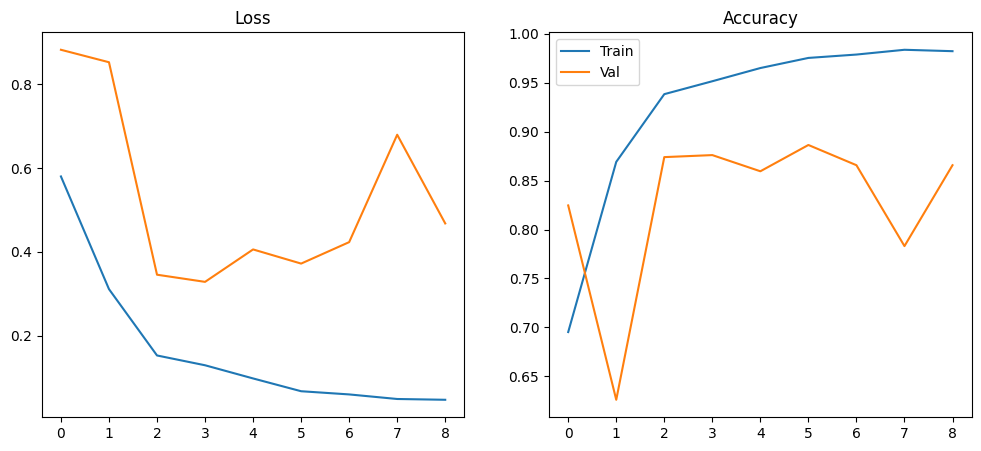

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()
plt.show()


In [65]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

img_path = r"C:\Users\harsh\Downloads\28455641\TN5000_forReview\TN5000\JPEGImages\004963.jpg"

# Step 1: Check existence
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")

# Step 2: Read image
img = cv2.imread(img_path)

if img is None:
    raise ValueError("cv2.imread failed. Check image format or path.")

# Step 3: Preprocess
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
x = preprocess_input(np.expand_dims(img, axis=0))


In [67]:
model.load_weights("thyroid_resnet50_best.h5")

pred = model.predict(x)[0]
cls = np.argmax(pred)
conf = pred[cls] * 100

label = "Malignant" if cls == 1 else "Benign"

print(f"Prediction: {label}")
print(f"Confidence: {conf:.2f}%")


1/1 [==============================] - 0s 100ms/step
Prediction: Malignant
Confidence: 100.00%


In [68]:
def gradcam(model, img_array, layer="conv5_block3_out"):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = tf.reduce_sum(conv_out[0] * pooled, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    return heatmap


In [69]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2


In [73]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-10)

    return heatmap, int(class_idx)


In [75]:
img_path = f"{IMG_DIR}/{val_ids[0]}.jpg"   # SAFE TEST IMAGE

# Read image
orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

img = cv2.resize(orig, (224,224))
img_input = preprocess_input(np.expand_dims(img, axis=0))

# Prediction
pred = model.predict(img_input)[0]
cls = np.argmax(pred)
conf = pred[cls] * 100

print("Prediction:", "Malignant" if cls==1 else "Benign")
print(f"Confidence: {conf:.2f}%")

# Grad-CAM
heatmap, _ = make_gradcam_heatmap(img_input, model)


1/1 [==============================] - 0s 95ms/step
Prediction: Benign
Confidence: 53.88%


1/1 [==============================] - 0s 94ms/step
Prediction: Benign
Confidence: 53.88%
Grad-CAM saved at:
gradcam_outputs\gradcam_benign_53.88.jpg


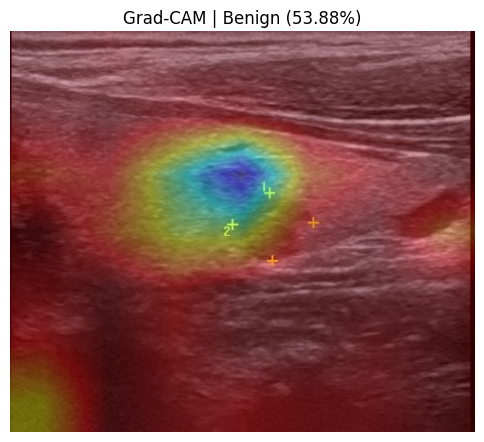

In [76]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

SAVE_DIR = "gradcam_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- Load Image ---
img_path = f"{IMG_DIR}/{val_ids[0]}.jpg"

orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

img = cv2.resize(orig, (224,224))
img_input = preprocess_input(np.expand_dims(img, axis=0))

# --- Prediction ---
pred = model.predict(img_input)[0]
cls = np.argmax(pred)
conf = pred[cls] * 100

print("Prediction:", "Malignant" if cls==1 else "Benign")
print(f"Confidence: {conf:.2f}%")

# --- Grad-CAM ---
heatmap, _ = make_gradcam_heatmap(img_input, model)

heatmap_resized = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap_resized),
    cv2.COLORMAP_JET
)

# --- Overlay ---
overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

# --- Save ---
overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
save_path = os.path.join(
    SAVE_DIR,
    f"gradcam_{'malignant' if cls==1 else 'benign'}_{conf:.2f}.jpg"
)

cv2.imwrite(save_path, overlay_bgr)

print("Grad-CAM saved at:")
print(save_path)

# --- Display ---
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"Grad-CAM | {'Malignant' if cls==1 else 'Benign'} ({conf:.2f}%)")
plt.axis("off")
plt.show()


1/1 [==============================] - 1s 1s/step
Prediction: Benign
Confidence: 98.72%
Grad-CAM image saved at:
gradcam_outputs\gradcam_benign_98.72.jpg


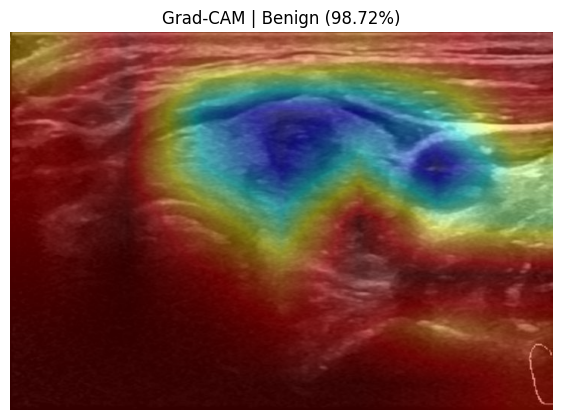

In [97]:
# =========================
# IMPORTS
# =========================
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# =========================
# CONFIG (EDIT THESE ONLY)
# =========================
MODEL_PATH = "thyroid_resnet50_best.h5"
IMAGE_PATH = r"C:\Users\harsh\separated_images_thyroid\Benign\000047.jpg"
SAVE_DIR = "gradcam_outputs"
IMG_SIZE = 224
CLASS_NAMES = ["Benign", "Malignant"]
LAST_CONV_LAYER = "conv5_block3_out"

# =========================
# SAFETY CHECKS
# =========================
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Model file not found")

if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError("Image file not found")

os.makedirs(SAVE_DIR, exist_ok=True)

# =========================
# LOAD MODEL
# =========================
model = tf.keras.models.load_model(MODEL_PATH)

# =========================
# LOAD & PREPROCESS IMAGE
# =========================
orig = cv2.imread(IMAGE_PATH)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

img = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))
img_input = preprocess_input(np.expand_dims(img, axis=0))

# =========================
# PREDICTION
# =========================
pred = model.predict(img_input)[0]
cls = int(np.argmax(pred))
conf = pred[cls] * 100

print(f"Prediction: {CLASS_NAMES[cls]}")
print(f"Confidence: {conf:.2f}%")

# =========================
# GRAD-CAM FUNCTION
# =========================
def make_gradcam_heatmap(img_array, model, layer_name):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-10)

    return heatmap

# =========================
# GENERATE GRAD-CAM
# =========================
heatmap = make_gradcam_heatmap(img_input, model, LAST_CONV_LAYER)

heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

# =========================
# SAVE OUTPUT
# =========================
save_path = os.path.join(
    SAVE_DIR,
    f"gradcam_{CLASS_NAMES[cls].lower()}_{conf:.2f}.jpg"
)

cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

print("Grad-CAM image saved at:")
print(save_path)

# =========================
# DISPLAY RESULT
# =========================
plt.figure(figsize=(7,7))
plt.imshow(overlay)
plt.title(f"Grad-CAM | {CLASS_NAMES[cls]} ({conf:.2f}%)")
plt.axis("off")
plt.show()


In [5]:
import tkinter as tk
from tkinter import filedialog
import cv2, os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageTk
from tensorflow.keras.applications.resnet50 import preprocess_input

# ---------------- CONFIG ----------------
MODEL_PATH = "new_thyroid_resnet50_best.h5"
IMG_SIZE = 224
CLASS_NAMES = ["Benign", "Malignant"]
LAST_CONV = "conv5_block3_out"

# ---------------- LOAD MODEL ----------------
model = tf.keras.models.load_model(MODEL_PATH)

# ---------------- GRAD-CAM ----------------
def gradcam(img_array):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(LAST_CONV).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)

        # 🔥 CRITICAL FIX (handles single-output & multi-output models)
        if isinstance(preds, (list, tuple)):
            preds = preds[0]

        cls = tf.argmax(preds[0])
        loss = preds[:, cls]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    confidence = float(tf.reduce_max(preds))
    return heatmap.numpy(), int(cls.numpy()), confidence

    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(LAST_CONV).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        cls = tf.argmax(preds[0])
        loss = preds[:, cls]

    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(conv_out[0] * pooled, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-10)
    return heatmap, int(cls), preds[0][cls].numpy()

# ---------------- PREDICT FUNCTION ----------------
def load_and_predict():
    path = filedialog.askopenfilename()
    if not path:
        return

    orig = cv2.imread(path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    img = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))
    x = preprocess_input(np.expand_dims(img, 0))

    heatmap, cls, conf = gradcam(x)
    conf *= 100

    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)

    # Display Image
    show_img = ImageTk.PhotoImage(Image.fromarray(overlay).resize((300,300)))
    image_label.config(image=show_img)
    image_label.image = show_img

    result_label.config(
        text=f"Prediction: {CLASS_NAMES[cls]}\nConfidence: {conf:.2f}%"
    )

# ---------------- TKINTER UI ----------------
root = tk.Tk()
root.title("Thyroid Disorder Detection (Grad-CAM)")
root.geometry("350x450")

tk.Button(root, text="Select Image", command=load_and_predict).pack(pady=10)

image_label = tk.Label(root)
image_label.pack()

result_label = tk.Label(root, text="", font=("Arial", 12))
result_label.pack(pady=10)

root.mainloop()
